In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.stats as stats
from scipy.stats import binom
import scipy
import itertools
from collections import Counter
from collections import defaultdict
import collections
import functools
import Bio
from Bio import motifs
import multiprocessing as mp
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
import os
import sys

%matplotlib inline

In [2]:
#sel_address = 'Z:/PROJECTS/Synthetic Promoters/Library#1/Hits Testing/tre_analysis_selectedseqs.csv'
sel_address = 'c:/users/wolf/desktop/synpro/tre_analysis_selectedseqs.csv'
sel_df = pd.read_csv(sel_address)


In [3]:
#libaddress = 'Z:/PROJECTS/Synthetic Promoters/Library#1/Hits Testing/Jaspar_lib.txt'
libaddress = 'C:/Users/Wolf/Documents/BioScripts/Jaspar_lib.txt'
fh = open(libaddress)

#Collect all TRE names, in order
with open(libaddress, 'r') as f:
    name_lst = []
    for ln in f:
        if ln.startswith('>'):
            name_lst.append(ln[10:-1])

#get frequency matrix for each TRE
pssms = [m.counts.normalize(pseudocounts=0.25).log_odds() for m in motifs.parse(fh, "jaspar")]

In [4]:
tre_lens = [len(pwm[0]) for pwm in pssms]
tre_len_dict = list(zip(name_lst, tre_lens))
trelen_df = pd.DataFrame(tre_len_dict, columns = ['tre', 'tre_len'])
trelen_df.head()

,tre,tre_len
0,RUNX1,11
1,TFAP2A,11
2,Arnt,6
3,Ahr::Arnt,6
4,Ar,17


In [5]:
jsel_df = pd.merge(sel_df, trelen_df, on='tre', how='inner')
jsel_df['Sequence'] = jsel_df['Sequence'].apply(lambda x: x.upper())
jsel_df['cposition'] = np.where(jsel_df['position'] >= 0, jsel_df['position'], 
                                ( jsel_df['Sequence'].str.len() + jsel_df['position']))
#                                ( jsel_df['Sequence'].str.len() + jsel_df['position'] - jsel_df['tre_len']))

In [6]:
import re
junc_matches = []
for seq in jsel_df['Sequence'].values:
    match = [m.start() for m in re.finditer('TCGA', seq)]
    junc_matches.append(match)
jsel_df['scar_ind'] = junc_matches
print(len(junc_matches))

2884


In [7]:
def is_overlapping(x1,x2,y1,y2):
    return max(x1,y1) <= min(x2,y2)

formed_juncs = []
for i, ind_lst in enumerate(jsel_df['scar_ind'].values):
    x1 = jsel_df['cposition'].values[i]
    x2 = jsel_df['cposition'].values[i] + jsel_df['tre_len'].values[i]
    
    bool_lst = []
    for ind_i in ind_lst:
        y1 = ind_i
        y2 = ind_i + 4
        bool_lst.append(is_overlapping(x1,x2,y1,y2))
        
    if True in bool_lst:
        formed_juncs.append(True)
    else:
        formed_juncs.append(False)
    
    
print(len(formed_juncs))

2884


In [8]:
jsel_df['formed_by_junction'] = formed_juncs
not_junc = set(jsel_df['tre'].loc[jsel_df['formed_by_junction'] == False])
print(not_junc)
print(len(not_junc))

{'FOS::JUN', 'ZNF740', 'REL', 'TBR1', 'EOMES', 'KLF16', 'SP1', 'NFATC2', 'KLF5', 'MEIS3', 'Klf4', 'TBX2', 'SMAD3', 'RELA'}
14


In [9]:
selected_tres = ['REL', 'RELA', 'SP1', 'STAT4', 'EGR1', 'E2F1', 'FOS::JUN', 'FOS', 
               'FOSL1', 'FOSL2', 'ARNT::HIF1A', 'NFATC1', 'NFATC2', 'NFATC3', 'NFAT5',
              'LEF1', 'SPI1', 'STAT4']
opt_test = ['true_not_junc' for t in not_junc if t in selected_tres]
print(opt_test)

['true_not_junc', 'true_not_junc', 'true_not_junc', 'true_not_junc', 'true_not_junc']


In [10]:
scar_address = 'Z:/PROJECTS/Synthetic Promoters/Library#1/Hits Testing/Junction_Test.csv'
jsel_df.sort_values('Name', inplace=True)
jsel_df.head()
#jsel_df.to_csv(scar_address, index=False)
def cell_lister(df):
    return [[x] for x in df]
jsel_df['complement'] = np.where(jsel_df['position'] > 0, '', 'complement(')

In [11]:
jsel_df.head(40)

,Name,Sequence,tre,position,logprob,tre_len,cposition,scar_ind,formed_by_junction,complement
1825,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,Tcf7,55,19.101097,12,55,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,
2123,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,Creb5,130,14.437469,12,130,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,
2122,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,Creb5,-155,12.482085,12,101,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,complement(
2121,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,Creb5,101,14.437469,12,101,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,
87,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,FOS::JUN,165,11.726842,7,165,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",False,
446,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,BATF::JUN,-91,12.666359,11,165,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,complement(
1068,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,JUND,-93,11.829899,11,163,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,complement(
1067,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,JUND,163,15.321106,11,163,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,
1511,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,JDP2,164,13.401359,9,164,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,
1512,S1-1,CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...,JDP2,-92,13.461868,9,164,"[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...",True,complement(


In [12]:
anno_df = jsel_df
col_list = ['tre', 'cposition', 'tre_len', 'complement']
for ele in col_list:  
    anno_df[ele] = cell_lister(anno_df[ele].values)
intermed_anno = anno_df.groupby('Name', as_index=False).agg({'tre': 'sum', 'tre_len': 'sum', 'cposition':'sum', 'scar_ind':'sum', 
                                                             'complement': 'sum'})


In [13]:
purged_jsel = jsel_df[['Name', 'Sequence']].drop_duplicates()
gb_df = pd.merge(intermed_anno, purged_jsel, left_on='Name', right_on='Name', how='inner')
gb_df.head(40)

,Name,tre,tre_len,cposition,scar_ind,complement,Sequence
0,S1-1,"[Tcf7, Creb5, Creb5, Creb5, FOS::JUN, BATF::JU...","[12, 12, 12, 12, 7, 11, 11, 11, 9, 9, 12, 11, ...","[55, 130, 101, 101, 165, 165, 163, 163, 164, 1...","[35, 53, 68, 83, 98, 115, 127, 144, 159, 173, ...","[, , complement(, , , complement(, complement(...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...
1,S1-10,"[SMAD3, TCF7L2, SMAD3, NFE2, MEIS3, FOS, NFE2,...","[10, 14, 10, 11, 8, 11, 11, 10, 14, 14, 14, 11...","[218, 93, 218, 170, 235, 200, 51, 141, 185, 18...","[35, 47, 61, 76, 91, 106, 123, 138, 152, 167, ...","[, , complement(, complement(, , complement(, ...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATTTGGCG...
2,S1-14,"[FOS, Bcl6, JDP2(var.2), Bcl6, FOSL2, FOSL1, J...","[11, 14, 12, 14, 11, 11, 13, 13, 13, 11, 11, 1...","[189, 216, 175, 201, 56, 55, 39, 108, 173, 82,...","[35, 52, 66, 78, 92, 104, 121, 136, 151, 169, ...","[complement(, complement(, complement(, comple...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGAAAGATGA...
3,S1-15,"[Klf4, EGR1, EGR1, FOS::JUN, FOS::JUN, FOSL2, ...","[10, 14, 14, 7, 7, 11, 11, 11, 11, 11, 14, 11,...","[137, 133, 209, 71, 151, 68, 194, 194, 54, 150...","[35, 50, 65, 79, 91, 106, 121, 132, 146, 160, ...","[, complement(, complement(, , complement(, , ...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGAAGATCAA...
4,S1-16,"[STAT3, STAT3, STAT3, STAT3, ZNF740, REL, Bcl6...","[11, 11, 11, 11, 10, 10, 14, 15, 15, 10, 10, 1...","[54, 54, 223, 223, 262, 192, 54, 213, 109, 177...","[35, 50, 65, 80, 97, 112, 126, 141, 155, 172, ...","[, complement(, , complement(, , , , , complem...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGAGGAGGAA...
5,S1-17,"[FOS, FOSL1, FOSL1, FOSL1, FOSL1, FOS, FOSL2, ...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 1...","[174, 54, 54, 174, 174, 174, 53, 251, 173, 254...","[35, 50, 64, 79, 94, 109, 126, 141, 156, 171, ...","[complement(, , complement(, complement(, , , ...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGAGGAGGAA...
6,S1-18,"[SP8, JUN(var.2), BATF::JUN, JUN(var.2), BATF:...","[12, 14, 11, 14, 11, 11, 15, 14, 14, 7, 7, 11,...","[97, 234, 231, 229, 56, 54, 96, 96, 55, 56, 23...","[35, 50, 64, 79, 94, 108, 123, 138, 155, 170, ...","[, complement(, , , complement(, , , , complem...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGAGGGGACT...
7,S1-19,"[TFAP2B(var.3), TCF7L2, Stat5a::Stat5b, TFAP2B...","[13, 14, 11, 13, 14, 10, 13, 13, 21, 10, 8, 11...","[138, 85, 73, 139, 39, 193, 207, 28, 47, 118, ...","[35, 53, 68, 83, 98, 113, 128, 143, 158, 173, ...","[, , complement(, complement(, , complement(, ...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGATCTCCGC...
8,S1-2,"[KLF14, JUNB, FOSL1, FOSL1, NFATC2, EOMES, FOS...","[14, 11, 11, 11, 7, 13, 7, 10, 11, 15, 11, 15,...","[107, 37, 95, 38, 185, 258, 40, 108, 39, 107, ...","[35, 49, 64, 79, 91, 105, 119, 134, 149, 164, ...","[, , complement(, complement(, , complement(, ...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGAATGAGTC...
9,S1-26,"[JUNB, SP1, KLF16, Creb5, JUND, ATF7, SP2, JUN...","[11, 11, 11, 12, 11, 14, 15, 14, 7, 12, 14, 10...","[112, 97, 205, 41, 111, 40, 93, 107, 58, 165, ...","[35, 52, 67, 78, 90, 108, 122, 133, 148, 163, ...","[complement(, complement(, , , , , complement(...",CTGCTTAGGGTTAGGCGTTTTGCGCTGCTTCGCGATCGAAAGATGA...


In [ ]:
for i, r in gb_df.iterrows():
    #write_directory = 'Z:/PROJECTS/Synthetic Promoters/Library#1/Hits Testing/Annotated_Sequences'
    #write_directory = 'c:/users/wolf/desktop/SynPro/GB_files'
    write_file = os.path.join(write_directory, str(r['Name']) + '.gb')
    with open(write_file, 'w') as f:
        f.write('LOCUS\t' + str(r['Name']) + '\t' + str(len(r['Sequence'])) + ' bp ds-dna\tlinear\n'
                + 'FEATURES\t\t\tLocation/Qualifiers')
    with open(write_file, 'a') as a:
        for n in range(len(r['tre'])):
            #Note +1 to cposition due to indexing difference, but not end cposition due to slicing difference
            a.write('\n\tTRE\t\t\t\t' + str(r['complement'][n]) + str(r['cposition'][n] + 1) + '..' + str(r['cposition'][n] + r['tre_len'][n]) 
                    + ')\n\t\t\t\t\t/label=' + '"' + str(r['tre'][n]) + '"')
        a.write('\nORIGIN\n\t' + str(r['Sequence']) + '\n//')

In [15]:
n_tres = [len(r['tre']) for i, r in gb_df.iterrows()]
count_df = gb_df[['Name']]
count_df['Number_of_TREs'] = n_tres
count_df['Sequence_length'] = [len(x) for x in gb_df['Sequence'].values]
count_destination = 'Z:/PROJECTS/Synthetic Promoters/Library#1/Hits Testing/Annotated_Sequences/TRE_count.csv'
count_df.to_csv(count_destination, index=False)
#count_df.head()

C:\Users\Wolf\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Wolf\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


FileNotFoundError: [Errno 2] No such file or directory: 'Z:/PROJECTS/Synthetic Promoters/Library#1/Hits Testing/Annotated_Sequences/TRE_count.csv'

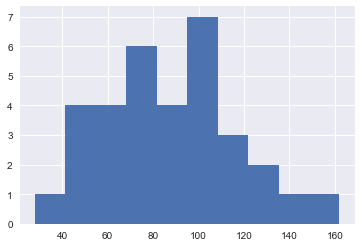

In [16]:
plt.hist(count_df['Number_of_TREs'].values)
plt.show()

In [17]:
s2n1 = Counter(gb_df['tre'].loc[gb_df['Name'] == 'S2-n1'].tolist()[0])
s6n1 = Counter(gb_df['tre'].loc[gb_df['Name'] == 'S6-n1'].tolist()[0])
s161 = Counter(gb_df['tre'].loc[gb_df['Name'] == 'S1-61'].tolist()[0])
#neg_set = s2n1.union(s6n1)
#excpt_s161 = (s161 - neg_set)
#print(excpt_s161)
#print(s161)
#print(s161 - s2n1)
#print(s161 - s6n1)
shared_diff = {key:val for key, val in (s161 - s2n1).items() if key in (s161 - s6n1)}
shared_diff

{'ATF7': 2,
 'BATF::JUN': 1,
 'Creb5': 2,
 'FOS': 2,
 'FOS::JUN': 1,
 'FOSL1': 2,
 'FOSL2': 2,
 'JDP2': 2,
 'JDP2(var.2)': 2,
 'JUN': 1,
 'JUN(var.2)': 2,
 'JUNB': 2,
 'JUND': 2,
 'JUND(var.2)': 2,
 'KLF5': 3,
 'Klf4': 2,
 'NFE2': 1,
 'REL': 1,
 'RELA': 1,
 'SP1': 3}

In [18]:
def tuple_ranger(tup):
    return list(range(tup[0], tup[1]))

all_tups = []
for i, r in gb_df.iterrows():
    row_tups = []
    for n in range(len(r['tre'])):
        row_tups.append(((r['cposition'][n]), (r['cposition'][n] + r['tre_len'][n])))
        #print(((r['cposition'][n]), (r['cposition'][n] + r['tre_len'][n])))
    all_tups.append(row_tups)
    #print([tuple_ranger(x) for x in row_tups])
print(all_tups)

[[(55, 67), (130, 142), (101, 113), (101, 113), (165, 172), (165, 176), (163, 174), (163, 174), (164, 173), (164, 173), (130, 142), (87, 98), (129, 143), (129, 143), (100, 114), (100, 114), (39, 54), (101, 113), (164, 175), (162, 173), (86, 97), (87, 98), (88, 99), (39, 49), (87, 98), (73, 83), (36, 51), (178, 188), (163, 174), (208, 218), (84, 98), (87, 101), (180, 194), (39, 53), (87, 98), (163, 174), (163, 174), (55, 69), (130, 145), (127, 142), (101, 116), (147, 161), (98, 113), (163, 174), (190, 204), (163, 174), (101, 113), (149, 161), (245, 256), (226, 236), (102, 115), (243, 251), (242, 252), (164, 178), (159, 173), (242, 253), (39, 50), (131, 144), (183, 197), (87, 101), (226, 236), (208, 218), (246, 256), (178, 188), (55, 70), (146, 161), (190, 205), (73, 83), (130, 142), (130, 142), (190, 202), (164, 175), (119, 131), (162, 173), (240, 253), (28, 41)], [(218, 228), (93, 107), (218, 228), (170, 181), (235, 243), (200, 211), (51, 62), (141, 151), (185, 199), (182, 196), (156, 

In [41]:
from itertools import chain
f_lr = []
for l in all_tups:
    l_lr = []
    for rs in l:
        l_lr.append(list(tuple_ranger(rs)))
    f_lr.append(list(set(chain(*l_lr))))
    
    
count_list = []
zero_list = []
for i, leng in enumerate(gb_df['Sequence'].str.len().tolist()):
    pos_list = []
    zlist = []
    for pos in range(leng):
        for rngs in all_tups[i]:
            concat_rng = list(chain(tuple_ranger(rngs)))
            if pos in tuple_ranger(rngs):
                pos_list.append(pos)
            else:
                if pos not in f_lr[i]:
                    zlist.append(pos)
    count_list.append(Counter(pos_list))
    zero_list.append({k:0 for k in set(zlist)})
merged_counts = [{**count_list[i], **zero_list[i]} for i in range(len(count_list))]

In [43]:
pos_df = pd.DataFrame(merged_counts)
#pos_df.fillna(0, inplace=True)
pos_df.head()

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


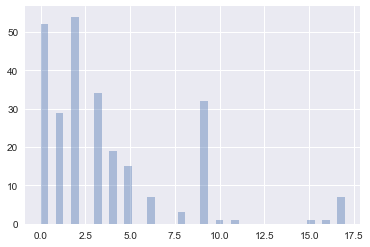

In [122]:
import math
sns.distplot([x for x in pos_df[0:1].values[0] if not math.isnan(x)],bins=40, kde=False)
plt.show()

In [113]:
all_params = []
all_filt = []
for i, r in pos_df.iterrows():
    nan_filtered = []
    for x in r:
        if not math.isnan(x):
            nan_filtered.append(x)
    all_params.append(stats.expon.fit(nan_filtered))
    all_filt.append(nan_filtered)
    #fgoodness = stats.curvefit('expon', )
    #print(params)

In [173]:
for n in range(len(all_filt)):
    y_obs = dict(Counter(all_filt[n]))
    y_max = int(max(y_obs.keys()))
    x = np.linspace(0, y_max, y_max+1)
    y_expect = stats.expon.pdf(x, all_params[n][0], all_params[n][1])

    y_tups = []
    for i in list(range(y_max + 1)):
        if i not in [int(k) for k in y_obs.keys()]:
            y_tups.append((i, 0))
        else:
            y_tups.append((i, y_obs[float(i)]))

    y_test = [x[1]/sum([x[1] for x in y_tups]) for x in y_tups]
    print(metrics.r2_score(y_test, y_expect))

0.623485446192
0.626866206062
0.642630795017
0.796176792727
0.593948034161
0.86313995662
0.679934189171
0.54979984066
0.764080184405
0.848711980076
0.822012850077
0.767438411801
0.743626231736
0.742795318532
0.720281666062
0.785977831279
0.70289825071
0.876359790359
0.590694086401
0.808767564363
0.664134580732
0.517099993676
0.839514651124
0.716122935335
0.697405666073
0.73937036516
0.827558108954
0.777991553197
0.764803063176
0.764837831586
0.657537050766
0.723870142099
0.704379818664


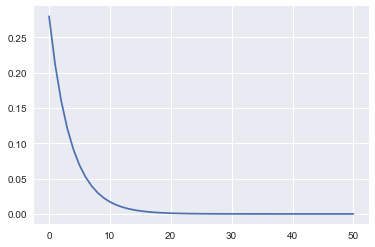

In [94]:
plt.scatter()